In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import regularizers
from keras.callbacks import EarlyStopping
from scipy.io import loadmat
import json
import numpy as np
import time

Using TensorFlow backend.


In [2]:
def plot_loss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_image(image):
    plt.imshow(image.reshape((28, 28)))    
    return

def plot_images_sample(images):
    plt.figure(figsize=(8, 5))
    plt.subplots_adjust(wspace=0, hspace=0)
    random_indices = random.sample(range(len(images)), 40)
    for i in range(40):
        plt.gray()
        subplot = plt.subplot(5, 8, i + 1)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)

        plot_image(images[random_indices[i]])

def plot_comparison(input_images, output_images):
    plt.figure(figsize=(18, 4))
    plt.subplots_adjust(wspace=0, hspace=0)
    random_indices = random.sample(range(len(input_images)), 12)
    for i in range(12):
        plt.gray()
        subplot = plt.subplot(2, 12, i + 1)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        plot_image(input_images[random_indices[i]])
        subplot = plt.subplot(2, 12, i + 1 + 12)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        plot_image(output_images[random_indices[i]])

def save_to_file(var, filename):
    js = json.dumps(var)
    f = open(filename, "w")
    f.write(js)
    f.close()

def load_from_file(filename):
    f = open(filename, "r")
    js = f.read()
    return json.loads(js)

In [3]:
training_epochs = 100
train_to_test_ratio = 0.85
input_size = 28 * 28
encoded_size = 7 * 7
activation = 'elu'
optimizer = 'adadelta'
loss = 'binary_crossentropy'
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
use_serialized = False

In [5]:
# load the dataset
mnist = loadmat("./Data/mnist-original")

# get the image data from the dataset
images = mnist["data"].T

# convert image data into float format
images = images / 255

label = mnist["label"]
# split into training and test images
train_count = round(len(images) * train_to_test_ratio)
test_count = len(images) - train_count
train_images = images[:train_count]
test_images = images[-test_count:]

print("all images:", images.shape)
print("train images:", train_images.shape)
print("test images:", test_images.shape)
label

all images: (70000, 784)
train images: (59500, 784)
test images: (10500, 784)


array([[0., 0., 0., ..., 9., 9., 9.]])

In [9]:
if (use_serialized):
    vanilla_autoencoder = load_model('vanilla.h5')
    vanilla_encoder = load_model('vanilla_encoder.h5')
    vanilla_decoder = load_model('vanilla_decoder.h5')

else:
    input_layer = Input(shape=(input_size,))
    
    # encoder
    encoded_layer = Dense(encoded_size, activation=activation)(input_layer)

    # decoder
    decoded_layer = Dense(input_size, activation='sigmoid')(encoded_layer)

    # autoencoder
    vanilla_autoencoder = Model(input_layer, decoded_layer)
    vanilla_autoencoder.name = "vanilla autoencoder"

    # separate encoder and decoder models
    vanilla_encoder = Model(input_layer, encoded_layer)
    vanilla_encoder.name = "vanilla encoder"

    encoded_input_layer = Input(shape=(encoded_size,))
    vanilla_decoder = Model(encoded_input_layer, vanilla_autoencoder.layers[-1](encoded_input_layer))
    vanilla_decoder.name = "vanilla decoder"

# print model summaries
vanilla_autoencoder.summary()
vanilla_encoder.summary()
vanilla_decoder.summary()

Model: "vanilla autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                38465     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________
Model: "vanilla encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                38465     
Total params: 38,4

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 3s 43us/step - loss: 0.3487 - val_loss: 0.2661
Epoch 2/100
59500/59500 [==============================] - 2s 41us/step - loss: 0.2577 - val_loss: 0.2422
Epoch 3/100
59500/59500 [==============================] - 2s 42us/step - loss: 0.2327 - val_loss: 0.2182
Epoch 4/100
59500/59500 [==============================] - 2s 42us/step - loss: 0.2120 - val_loss: 0.2011
Epoch 5/100
59500/59500 [==============================] - 2s 40us/step - loss: 0.1975 - val_loss: 0.1892
Epoch 6/100
59500/59500 [==============================] - 2s 42us/step - loss: 0.1871 - val_loss: 0.1802
Epoch 7/100
59500/59500 [==============================] - 3s 42us/step - loss: 0.1789 - val_loss: 0.1729
Epoch 8/100
59500/59500 [==============================] - 3s 43us/step - loss: 0.1720 - val_loss: 0.1666
Epoch 9/100
59500/59500 [==============================] - 3s 43us/step - loss: 0.1660 - val_loss: 0.1

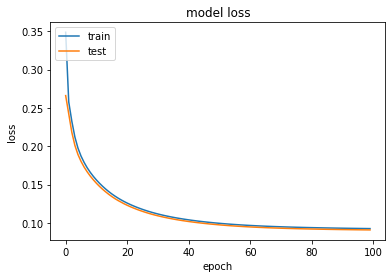

loss: 0.09260397751792139
val_loss: 0.09088229892367408


In [10]:
if (use_serialized):
    history = load_from_file('vanilla_history.json')
    
else:
    vanilla_autoencoder.compile(optimizer=optimizer, loss=loss)
    start = time.time()
    history = vanilla_autoencoder.fit(train_images, train_images, 
                            epochs=training_epochs, 
                            batch_size=256, 
                            shuffle=True, 
                            validation_data=(test_images, test_images),
                            callbacks=callbacks).history
    print('training time:', time.time() - start)
    save_to_file(history, 'vanilla_history.json')
    vanilla_autoencoder.save('vanilla.h5')
    vanilla_encoder.save('vanilla_encoder.h5')
    vanilla_decoder.save('vanilla_decoder.h5')    

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])


In [11]:
# encode images
encoded_images = vanilla_encoder.predict(test_images)
print("encoded images:", encoded_images.shape)

#decode images
decoded_images = vanilla_decoder.predict(encoded_images)
print("decoded images:", decoded_images.shape)

encoded images: (10500, 49)
decoded images: (10500, 784)


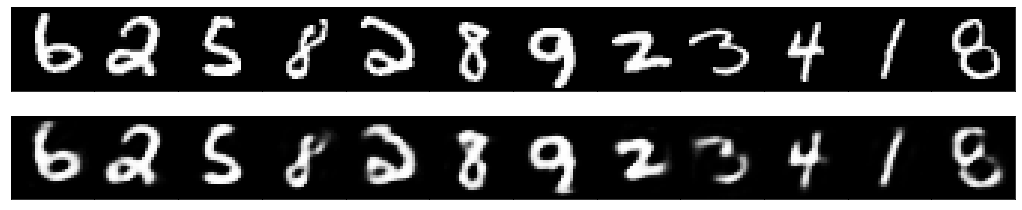

In [12]:
plot_comparison(test_images, decoded_images)